In [1]:
# from sklearn. import IterativeImputer


In [67]:
import os

import pandas as pd
import numpy as np
import lightgbm as lgb
import seaborn as sns
from datetime import timedelta
# from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from numpy.linalg import svd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [3]:
input_folder = '../data/input/'
data = pd.read_csv(os.path.join(input_folder, 'dengue_features_train.csv'))
labels = pd.read_csv(os.path.join(input_folder, 'dengue_labels_train.csv'))

In [4]:
# features.head()

In [5]:
# impute the missing values using KNN
imputer = KNNImputer(n_neighbors=3, weights="uniform")
features = imputer.fit_transform(data[data.columns[4:]])
features = pd.DataFrame(features, columns=data.columns[4:])


In [6]:
data = data.astype({'week_start_date': 'datetime64[ns]'}, copy=False)

In [7]:
columns_to_com = features.columns.tolist()
prefix = 'weekbefore_'

In [8]:
for col in columns_to_com:
    for i in features.index:
        if i > 0 and data.loc[i, 'city'] == data.loc[i-1, 'city']:
            features.loc[i, prefix+col] = features.loc[i-1, col]

In [9]:
prefix = 'week2_'
for col in columns_to_com:
    for i in features.index:
        if i > 1 and data.loc[i, 'city'] == data.loc[i-2, 'city']:
            features.loc[i, prefix+col] = features.loc[i-2, col]

In [10]:
prefix = 'week3_'
for col in columns_to_com:
    for i in features.index:
        if i > 2 and data.loc[i, 'city'] == data.loc[i-3, 'city']:
            features.loc[i, prefix+col] = features.loc[i-3, col]

In [11]:
prefix = 'week4_'
for col in columns_to_com:
    for i in features.index:
        if i > 3 and data.loc[i, 'city'] == data.loc[i-4, 'city']:
            features.loc[i, prefix+col] = features.loc[i-4, col]

In [12]:
f = imputer.fit_transform(features)
features = pd.DataFrame(f, columns=features.columns)
data = data[data.columns[:4]].join(features, how='inner')

In [13]:
data.tail()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,week4_reanalysis_precip_amt_kg_per_m2,week4_reanalysis_relative_humidity_percent,week4_reanalysis_sat_precip_amt_mm,week4_reanalysis_specific_humidity_g_per_kg,week4_reanalysis_tdtr_k,week4_station_avg_temp_c,week4_station_diur_temp_rng_c,week4_station_max_temp_c,week4_station_min_temp_c,week4_station_precip_mm
1451,iq,2010,21,2010-05-28,0.342750,0.318900,0.256343,0.292514,55.30,299.334286,...,23.60,87.657143,26.00,18.068571,8.257143,28.850000,12.125000,36.2,21.4,35.4
1452,iq,2010,22,2010-06-04,0.160157,0.160371,0.136043,0.225657,86.47,298.330000,...,85.46,96.712857,73.97,18.602857,5.714286,27.600000,9.600000,33.2,21.4,8.1
1453,iq,2010,23,2010-06-11,0.247057,0.146057,0.250357,0.233714,58.94,296.598571,...,87.30,97.445714,59.40,18.391429,6.185714,27.400000,10.400000,33.7,21.2,32.0
1454,iq,2010,24,2010-06-18,0.333914,0.245771,0.278886,0.325486,59.67,296.345714,...,8.80,78.998571,1.15,14.908571,11.242857,25.633333,9.200000,34.0,20.0,2.5
1455,iq,2010,25,2010-06-25,0.298186,0.232971,0.274214,0.315757,63.22,298.097143,...,45.00,88.765714,55.30,18.485714,9.800000,28.633333,11.933333,35.4,22.4,27.0


In [14]:
data['week_start_date'] = data.week_start_date.values.astype('float64') // 10**9
scaler = MinMaxScaler()
col_to_norm = [col for col in data.columns if data[col].dtypes == np.float64]
norm = scaler.fit_transform(data[col_to_norm])
data[col_to_norm] = norm

In [15]:
features = data[data.columns[3:]]
u, s, v = svd(features.values, full_matrices=False)

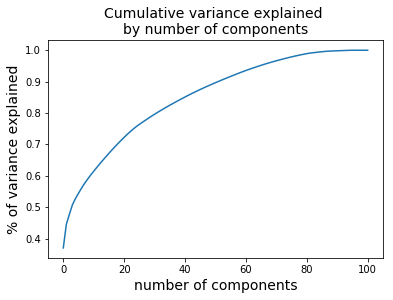

In [37]:
plt.plot(np.cumsum(s)/np.sum(s))
plt.xlabel('number of components', fontsize=14)
plt.ylabel('% of variance explained', fontsize=14)
plt.title('Cumulative variance explained \nby number of components', fontsize=14)
plt.savefig("../data/output/pca.png")


In [17]:
ncomp = 75
(np.cumsum(s)/np.sum(s))[ncomp]

0.9788881384278572

In [18]:
v = v.T
features_hat = np.dot(features, v[:, :ncomp])

In [19]:
features_hat = pd.DataFrame(features_hat, columns=['com'+str(i+1) for i in range(features_hat.shape[1])])
data = data[data.columns[:3]].join(features_hat, how='inner')

In [20]:
data = data.astype({'city': 'category', 'year': 'category', 'weekofyear': 'category'}, copy=False) 
labels = labels.astype({'city': 'category', 'year': 'category', 'weekofyear': 'category'}, copy=False) 

In [21]:
X_train, X_val, y_train, y_val = train_test_split(data, labels['total_cases'], test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [22]:

lgb_train = lgb.Dataset(X_train, y_train, 
                        feature_name = list(X_train.columns), 
                        categorical_feature = ['city', 'weekofyear', 'year']
)
lgb_val = lgb.Dataset(X_val, y_val, 
                        feature_name = list(X_val.columns), 
                        categorical_feature =  ['city', 'weekofyear', 'year'] #['year', 'weekofyear', 'week_start_date']
)

In [23]:
params = {
 'task': 'train',
  'boosting_type': 'gbdt',
  'min_chile_samples': 5,
  'num_leaves': 31,
  'n_estimators': 200,
  'objective': 'regression', # if is_regression == True else 'multiclass',
  'metric': 'rmsle', #'rmsle', # if is_regression == True else 'multi_logloss',
  'min_data': 1,
  'verbose': -1
}
 
gbm = lgb.train(params, lgb_train, num_boost_round=100, valid_sets=[lgb_val, lgb_train], valid_names=['eval', 'train'])

C:\Users\Martins\Anaconda3\lib\site-packages\lightgbm\engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\Martins\Anaconda3\lib\site-packages\lightgbm\basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\Martins\Anaconda3\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


In [68]:
predictions = gbm.predict(X_test)
mae = mean_absolute_error(predictions, y_test)
r2 = r2_score(predictions, y_test)
rmse = np.sqrt(mean_squared_error(predictions, y_test))
print(f'R2 score = {r2},  MAE = {mae},  RMSE = {rmse}')

R2 score = 0.24689566911508343,  MAE = 10.509728976712319,  RMSE = 21.058612893510723


In [25]:
submission = pd.read_csv(os.path.join(input_folder, 'submission_format.csv'))
submission.head()

,city,year,weekofyear,total_cases
0,sj,2008,18,0
1,sj,2008,19,0
2,sj,2008,20,0
3,sj,2008,21,0
4,sj,2008,22,0


In [26]:
for i, row in submission.iterrows():
    print(row)
    break

city             sj
year           2008
weekofyear       18
total_cases       0
Name: 0, dtype: object


In [27]:
data.head()

,city,year,weekofyear,com1,com2,com3,com4,com5,com6,com7,...,com66,com67,com68,com69,com70,com71,com72,com73,com74,com75
0,sj,1990,18,-4.191085,0.705030,-0.434319,0.021242,0.186170,0.171262,-0.559197,...,-0.017178,0.011100,0.062521,-0.015646,-0.029909,-0.007733,-0.000768,0.007111,-0.000409,-0.020582
1,sj,1990,19,-4.039240,0.555688,-0.440043,0.151095,0.274502,0.101275,-0.337240,...,0.026754,0.011039,0.037746,-0.041645,-0.047391,0.001129,0.012737,0.023060,-0.019162,-0.016492
2,sj,1990,20,-4.199797,0.545794,-0.566129,0.079934,0.371858,0.025634,-0.087709,...,-0.025915,-0.048276,0.020435,0.011677,-0.033204,0.024580,0.005577,-0.018649,0.015556,0.032187
3,sj,1990,21,-4.302306,0.556289,-0.498080,0.171292,0.454469,-0.005096,0.146922,...,-0.023314,0.055135,0.016587,0.019169,-0.035454,-0.006036,-0.038947,-0.032721,-0.001041,0.022893
4,sj,1990,22,-4.488446,0.513734,-0.522379,0.279017,0.575527,-0.257430,0.392577,...,0.012881,-0.026525,0.004184,-0.022489,0.038986,-0.007643,-0.024453,-0.052456,-0.020929,-0.006024


In [29]:
data.loc[(data['city'] == 'sj') & (data['year'] == 2008) &  (data['weekofyear'] == 18)]

,city,year,weekofyear,com1,com2,com3,com4,com5,com6,com7,...,com66,com67,com68,com69,com70,com71,com72,com73,com74,com75


In [31]:
data.year.unique()

[1990, 1991, 1992, 1993, 1994, ..., 2006, 2007, 2008, 2009, 2010]
Length: 21
Categories (21, int64): [1990, 1991, 1992, 1993, ..., 2007, 2008, 2009, 2010]

C:\Users\Martins\Anaconda3\lib\site-packages\seaborn\axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


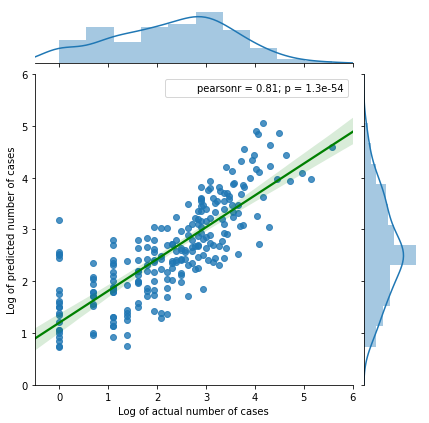

In [65]:
# pd.DataFrame({'actual': y_test, 'predicted': predictions})
import scipy.stats as stats
sns.jointplot(np.log1p(y_test), np.log1p(predictions), kind='reg', joint_kws={'line_kws':{'color':'green'}}).annotate(stats.pearsonr)
plt.xlabel('Log of actual number of cases')
plt.ylabel('Log of predicted number of cases')
plt.xlim([-0.5, 6]); plt.ylim([0, 6])
plt.savefig("../data/output/predicted_observed.png")